In [33]:
import networkx as nx
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from copy import copy
import pandas as pd
import warnings
np.seterr(all='warn')
warnings.filterwarnings('error')

In [34]:
def draw_graph(G):
    pos = nx.spring_layout(G)
    nx.draw(G,pos=pos)
    nx.draw_networkx_labels(G,pos=pos)
    plt.show()

In [35]:
def ranks(A,d=0.85,maxIter=100):
    out_edge_sum = A.sum(axis=1)
#     B= np.multiply(A,(1/out_edge_sum))
    Abool = np.matrix(A,dtype=bool)
    
    def r_u_vec(d,r_in,out_edge_sum):
        r_out = copy(r_in)
        for u in range(max(r_out.shape)):
            r_out[u] = r_u(u,r_in,out_edge_sum)
        return d * r_out

#     @printwrapper
    def r_u(u,rankings,out_edge_sum):
        summed = 0 

        for v,v_enters_u in enumerate(Abool[:,u]):
            if v_enters_u:
                summed += rankings[v]/out_edge_sum[v]
        return summed        
            
            

    r= np.ones(A[:,0].shape)
    r= r/float(max(r.shape))

    for i in range(maxIter):
        r=r_u_vec(d,r,out_edge_sum)
    return r/max(r)
            

In [36]:
def vectorized_ranks(A):
    B=np.multiply(A,1/np.sum(A,axis=1))
    v,w= np.linalg.eig(B.T)
    w[:,0]
    lvec= abs(w[:,0])
    return lvec/max(lvec)

In [37]:
def nx_pagerank(G):
    res = np.matrix(np.array([value for label,value in nx.pagerank(G).items()])).T
    return res/max(res)

In [38]:
def printwrapper(func):
    def result(*args,**kwargs):
        res = func(*args,**kwargs)
        print("in : {}, out : {} \n".format(args,res))
        return res
    return result

def compare_simple_rank(G):
    A= nx.adj_matrix(G).todense()
    df = pd.DataFrame(np.hstack((ranks(A),vectorized_ranks(A),nx_pagerank(G))))
    df.rename(columns={0: 'Ranks', 1: 'vectorized_ranks',2:"networkx_pagerank"}, inplace=True)
    return df

def compare_simple_rank(G):
    A= nx.adj_matrix(G).todense()
    try:
        df = pd.DataFrame(np.hstack((ranks(A),vectorized_ranks(A),nx_pagerank(G))))
        df.rename(columns={0: 'Ranks', 1: 'vectorized_ranks',2:"networkx_pagerank"}, inplace=True)
    except RuntimeWarning:
        df = pd.DataFrame(np.hstack((ranks(A),nx_pagerank(G))))
        df.rename(columns={0: 'Ranks', 1:"networkx_pagerank"}, inplace=True)
    return df


# Example1

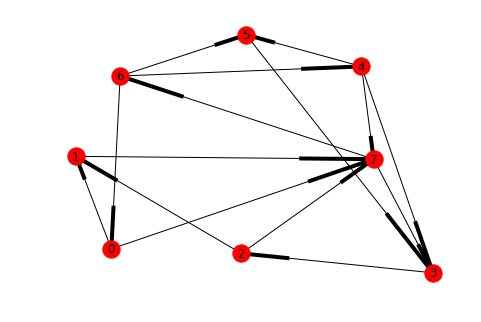

In [39]:
G = nx.read_edgelist('edges.txt',create_using=nx.DiGraph(),nodetype=int)
draw_graph(G)


In [40]:
compare_simple_rank(G)

Ranks  vectorized_ranks  networkx_pagerank
0  0.166667          0.166667           0.224866
1  0.472222          0.472222           0.506105
2  0.777778          0.777778           0.774472
3  0.777778          0.777778           0.815387
4  0.166667          0.166667           0.224866
5  0.222222          0.222222           0.288577
6  0.500000          0.500000           0.506388
7  1.000000          1.000000           1.000000

A[i][j]=1   =>  jest krawędź z i do j

Wychodzące : row

Wchodzące: : col

# Example 2

In [41]:
def generate_graph(n=7):
    G2 =nx.gnc_graph(n)
    random= lambda:np.random.randint(0,9)
    random_node= lambda n:np.random.randint(0,n-1)
    for i in range(n):
        r=random()
        edge=None
        if r<3:
            edge= (n,random_node(n))
        elif r<6:
            edge = (random_node(n),n)
        if edge and not edge in G2.edges():
            G2.add_edge(*edge)
    return G2

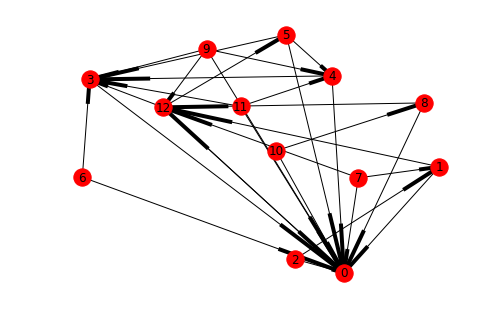

In [64]:
G2= generate_graph(12)
draw_graph(G2)

In [66]:
compare_simple_rank(G2)

Ranks  vectorized_ranks  networkx_pagerank
0   1.000000          1.000000           1.000000
1   0.000000          0.000000           0.063848
2   0.000000          0.000000           0.037375
3   0.500000          0.500000           0.490739
4   0.111111          0.111111           0.143217
5   0.333333          0.333333           0.308147
6   0.000000          0.000000           0.037375
7   0.000000          0.000000           0.037375
8   0.000000          0.000000           0.053259
9   0.000000          0.000000           0.037375
10  0.000000          0.000000           0.037375
11  0.000000          0.000000           0.037375
12  1.000000          1.000000           0.955673

# Page_rank()

In [67]:
def page_rank(A,d=0.85,maxIter=10,e=None):
    out_edge_sum = A.sum(axis=1)
#     B= np.multiply(A,(1/out_edge_sum))
    Abool = np.matrix(A,dtype=bool)
    
    def r_u_vec(d,r_in,out_edge_sum):
        r_out = copy(r_in)
        for u in range(max(r_out.shape)):
            r_out[u] = r_u(u,r_in,out_edge_sum)
        return d * r_out

#     @printwrapper
    def r_u(u,rankings,out_edge_sum):
        summed = 0 

        for v,v_enters_u in enumerate(Abool[:,u]):
            if v_enters_u:
                summed += rankings[v]/out_edge_sum[v]
        return summed        
            
            

    r= np.ones(A[:,0].shape)
    r= r/float(max(r.shape))
    if e is None:
        e=r

    for i in range(maxIter):
        r=r_u_vec(d,r,out_edge_sum) +(1-d)*e
    return r/max(r)
    

In [68]:
def page_rank_vectorized(A,d=0.85,e=None):
    n = A.shape[0]
    B=np.multiply(A,1/np.sum(A,axis=1))
    
    if e is None:
        e = np.ones((n,1))/n

    B2 = d*B +(1-d)* np.outer(e,np.ones((n,1)))
    
    v,w= np.linalg.eig(B2.T)
    w[:,0]
    lvec= abs(w[:,0])
    return lvec/max(lvec)

In [93]:
def compare_page_rank(G,d=0.85):
    A= nx.adj_matrix(G).todense()
    try:
        df = pd.DataFrame(np.hstack((page_rank(A,d=d),page_rank_vectorized(A,d=d),nx_pagerank(G))))
        df.rename(columns={0: 'page_rank', 1: 'vectorized_page_rank',2:"networkx_pagerank"}, inplace=True)
    except RuntimeWarning:
        df = pd.DataFrame(np.hstack((page_rank(A),nx_pagerank(G))))
        df.rename(columns={0: 'page_rank', 1:"networkx_pagerank"}, inplace=True)
    return df


In [98]:
compare_page_rank(G2,0.5)

page_rank  vectorized_page_rank  networkx_pagerank
0    1.000000              1.000000           1.000000
1    0.238900              0.238900           0.063848
2    0.168635              0.168635           0.037375
3    0.516768              0.516769           0.490739
4    0.268989              0.268989           0.143217
5    0.307009              0.307009           0.308147
6    0.168635              0.168635           0.037375
7    0.168635              0.168635           0.037375
8    0.210794              0.210794           0.053259
9    0.168635              0.168635           0.037375
10   0.168635              0.168635           0.037375
11   0.168635              0.168635           0.037375
12   0.830243              0.830244           0.955673

In [99]:
compare_page_rank(G2,0.7)

page_rank  vectorized_page_rank  networkx_pagerank
0    1.000000              1.000000           1.000000
1    0.132389              0.132390           0.063848
2    0.083614              0.083615           0.037375
3    0.491816              0.491832           0.490739
4    0.186483              0.186464           0.143217
5    0.294441              0.294456           0.308147
6    0.083614              0.083615           0.037375
7    0.083614              0.083615           0.037375
8    0.112879              0.112880           0.053259
9    0.083614              0.083615           0.037375
10   0.083614              0.083615           0.037375
11   0.083614              0.083615           0.037375
12   0.903587              0.903602           0.955673

In [100]:
compare_page_rank(G2,0.9)

page_rank  vectorized_page_rank  networkx_pagerank
0    1.000000              1.000000           1.000000
1    0.042170              0.042174           0.063848
2    0.024097              0.024100           0.037375
3    0.492629              0.492830           0.490739
4    0.131667              0.131413           0.143217
5    0.315342              0.315536           0.308147
6    0.024097              0.024100           0.037375
7    0.024097              0.024100           0.037375
8    0.034940              0.034944           0.053259
9    0.024097              0.024100           0.037375
10   0.024097              0.024100           0.037375
11   0.024097              0.024100           0.037375
12   0.971265              0.971455           0.955673

as d rises, so does gap between low ranks and high ranks ( alghoritm becomes more greedy ?)

# SNAP Facebook data

In [74]:
fbG = nx.read_edgelist('facebook_combined.txt',create_using=nx.DiGraph(),nodetype=int)

In [75]:
fbMatrix= nx.adjacency_matrix(fbG).todense()

In [76]:
#%timeit 
fb_res = page_rank(fbMatrix)

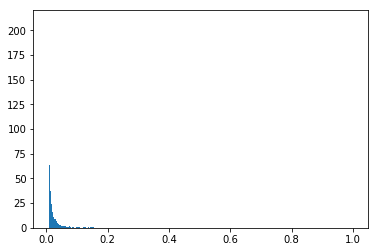

In [89]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(fb_res, normed=True, bins=1000)
plt.show()

High ranks are grouped in highly connected "circles". They aren't evenly distributed.